<a href="https://colab.research.google.com/github/tanynova99/2021-2-level-ctlr/blob/main/Budanova_Lab_3_Generative_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB 3 "Генерация текста"

- Вам предстоит создать и обучить генеративную нейронную сеть, с применением RNN и механизма Attention.

- Для генерации не допускается применять предобученные модели, использовать предобученные эмбеддинги можно.

- Для обучения вы можете выбрать любой датасет (можно брать как из предыдущих лаб, так и предложить свой).  

- После обучения модели вы должны написать функцию, которая принимает на вход необработанный текст и возвращает сгенерированное продолжение.

- В EDA вы должны доказать, что ваш датасет подходит для обучения модели (например, тексты не содержат какие-то метаданные, как было в датасете с песнями во второй лабе) и предобработать до нужного состояния, если это требуется.

- В выводах вы должны оценить качество генерируемых текстов: можете провести некоторый лингвистический анализ или оценить какими-нибудь метриками.

*Выполнение всего вышеперечисленного дает вам оценку 8. Для 10 вы должны обучить несколько моделей с отличными гиперпараметрами (например, размер входного окна) и попытаться сравнить их качество.*

*Для желающих есть усложненное задание: вместо RNN применить архитектуру трансформера.*

**Дедлайн 18.02 23:59**

- Сдавать сюда: https://forms.gle/P3iZ9MdyfmBW8gc67

In [ ]:
# !pip install pdfx

In [ ]:
# general imports
from google.colab import drive
import glob
import numpy as np
import re
from html.parser import HTMLParser
import tqdm
import pandas as pd
import pdfx

drive.mount('/content/drive')

# nn imports
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.layers import Input, Dense, GRU
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import mean_squared_error

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# The data

I picked Sartre's texts into the network for no apparent reason other than it sounds funny.

In addition, that sort of data isn't overly spammed with useless text.

In [ ]:
# uploading the txt data from my google drive into the pandas dataframe
# resulted in low quality imput, found .txt instead

'''pdf_files = glob.glob('/content/drive/MyDrive/UNIVERSITY STUFF/нейросетки/3/sartre textes (en)/*.pdf')
raw_text = []

for filename in pdf_files[:1]:
  print(filename)
  pdf = pdfx.PDFx(filename)
  text = pdf.get_text()
  raw_text.append(text.split('.'))
'''

"pdf_files = glob.glob('/content/drive/MyDrive/UNIVERSITY STUFF/нейросетки/3/sartre textes (en)/*.pdf')\nraw_text = []\n\nfor filename in pdf_files[:1]:\n  print(filename)\n  pdf = pdfx.PDFx(filename)\n  text = pdf.get_text()\n  raw_text.append(text.split('.'))\n"

In [ ]:
txt_files = glob.glob('/content/drive/MyDrive/UNIVERSITY STUFF/нейросетки/3/sartre textes (en)/*.txt')
raw_text = []

for filepath in txt_files:
  f = open(filepath, "r")
  print(filepath)
  text = f.read()
  text = text.split('\n')
  for i in text:
    raw_text.append(i)

/content/drive/MyDrive/UNIVERSITY STUFF/нейросетки/3/sartre textes (en)/Being and Nothingness An Essay on Phenomenological Ontology- Jean-Paul Sartre.txt
/content/drive/MyDrive/UNIVERSITY STUFF/нейросетки/3/sartre textes (en)/Existentialism is a Humanism - Jean-Paul Sartre.txt
/content/drive/MyDrive/UNIVERSITY STUFF/нейросетки/3/sartre textes (en)/The Imagination - Jean-Paul Sartre.txt
/content/drive/MyDrive/UNIVERSITY STUFF/нейросетки/3/sartre textes (en)/What Is Subjectivity - Jean-Paul Sartre.txt
/content/drive/MyDrive/UNIVERSITY STUFF/нейросетки/3/sartre textes (en)/Nausea - Jean-Paul Sartre.txt


In [ ]:
raw_text[:30]

['\ufeffTable of Contents',
 '',
 'INTRODUCTION',
 '',
 'The Pursuit of Being',
 '',
 'PART ONE',
 '',
 'THE PROBLEM OF NOTHINGNESS',
 '',
 'Chapter One. The Origin of Negation',
 '',
 'I. The Question',
 '',
 'II. Negations',
 '',
 'III. The Dialectical Concept of Nothingness',
 '',
 'IV. The Phenomenological Concept of Nothingness',
 '',
 'V. The Origin of Nothingness',
 '',
 'Chapter Two. Bad Faith',
 '',
 'I. Bad Faith and Falsehood',
 '',
 'II. Patterns of Bad Faith',
 '',
 'III. The “Faith” of Bad Faith',
 '']

# EDA

In [ ]:
# let's create a pandas dataframe

df_raw = pd.DataFrame(raw_text, columns=['text'])

In [ ]:
df_raw.head(30)

,text
0,﻿Table of Contents
1,
2,INTRODUCTION
3,
4,The Pursuit of Being
5,
6,PART ONE
7,
8,THE PROBLEM OF NOTHINGNESS
9,


## Remove rubbish from the dataset


- I removed books' prefaces and name indexes manually, because those were organized differently in books and contained dofferent parts (one had bibliography at the end of it, images links... No way I could caught that)

- Content's pages and the chapter's names (they're written in caps and accompanied by roman numerals)

- Some additional phrases that I noticed while looking at texts

In [ ]:
df_clear = df_raw

table_of_contents = r'[IV].*'
all_capital_names = r'[A-Z]{2,}:'
all_capital = r'[A-Z]{2,}'

df_clear = df_clear.replace(to_replace = table_of_contents, value = '', regex = True)
df_clear =  df_clear.replace(to_replace = all_capital_names, value = '', regex = True)
df_clear =  df_clear.replace(to_replace = all_capital, value = '', regex = True)

In [ ]:
df_clear = df_clear[~df_clear.text.str.contains("Table of Contents")]

In [ ]:
df_clear = df_clear[~df_clear.text.str.contains("Chapter")]

In [ ]:
# empty cells removal
df_clear = df_clear.replace(r'^\s*$', np.nan, regex=True).dropna(subset=['text'])

In [ ]:
df_clear

,text
4,The Pursuit of Being
122,Key to Special Terminology
126,The Pursuit of Being
130,thought has realized considerable progress by...
134,The obvious conclusion is that the dualism of ...
...,...
8549,The Negress sings. Can you justify your existe...
8551,Some of these days
8553,"You’ll miss me, honey"
8555,Couldn’t


In [ ]:
# there are also duplicates - the names of the parts that migh've been left out and empty strings
print("Number of duplicated rows: ", df_clear.duplicated().sum())

Number of duplicated rows:  264


In [ ]:
df_clear = df_clear.drop_duplicates()
print("Number of duplicated rows: ", df_clear.duplicated().sum())

Number of duplicated rows:  0


In [ ]:
df_clear

,text
4,The Pursuit of Being
122,Key to Special Terminology
130,thought has realized considerable progress by...
134,The obvious conclusion is that the dualism of ...
136,The duality of potency and act falls by the sa...
...,...
8545,Madeleine starts to laugh. She turns the crank...
8547,She sings. So two of them are saved: the Jew a...
8549,The Negress sings. Can you justify your existe...
8555,Couldn’t


# Embeddings

In [ ]:
from gensim.models import Word2Vec
word_model = Word2Vec(df_clear['text'].apply(lambda x: x.split()), min_count=1, vector_size=50, window=3, sg = 1)

In [ ]:
all_words = set(' '.join(df_clear['text'].values).split())
decode_BOW = {}
encode_BOW = {}

for i, word in enumerate(all_words):
    decode_BOW[i] = word
    encode_BOW[word] = i

len(decode_BOW)

15938

In [ ]:
word_model.wv.most_similar('nothingness')[:5]

[('act', 0.996894359588623),
 ('situation', 0.9965001940727234),
 ('defined', 0.996267557144165),
 ('transcendent', 0.9959158897399902),
 ('reflection', 0.9958268404006958)]

In [ ]:
tqdm.tqdm.pandas()
X = []
y_vector = []
y_bow = []
for _, i in tqdm.tqdm(df_clear.iterrows()):
  x_part = []
  if len(i['text'].split()) < 7:
    continue
  for token in i['text'].split()[-7:-1]:
    x_part.append(word_model.wv[token])
  X.append(np.array(x_part))
  y_vector.append(word_model.wv[i['text'].split()[-1]])
  y_bow.append(encode_BOW[i['text'].split()[-1]])

3011it [00:00, 10727.28it/s]


# Neural network: splits

In [ ]:
X = np.array(X)
y_vector = np.array(y_vector)

In [ ]:
X.shape

(2275, 6, 50)

In [ ]:
X[0][:2]

array([[-0.21651919,  0.3494633 ,  0.21626076,  0.25500724, -0.03996427,
        -0.5502975 ,  0.28861174,  0.9906084 , -0.55631256, -0.25461635,
         0.21248613, -0.3439866 ,  0.1181298 ,  0.13878778, -0.07239678,
        -0.05393448,  0.26189578,  0.49151748, -0.56183934, -0.9394115 ,
         0.18456537,  0.27462792,  0.9433881 , -0.31166694,  0.22052377,
         0.06325611, -0.00229016,  0.6270935 , -0.8576862 , -0.08379294,
        -0.19877133, -0.4516982 ,  0.25518683, -0.220599  , -0.14119469,
         0.09240447,  0.7255836 ,  0.13616015,  0.3288222 , -0.26461878,
        -0.12000673,  0.0360985 , -0.41225338,  0.0812273 ,  0.79337376,
        -0.10684013, -0.24175347,  0.2220161 ,  0.1140832 ,  0.42742166],
       [-0.07038482,  0.10561918,  0.10110154,  0.20272906, -0.09983738,
        -0.41917792,  0.27985707,  0.3266358 , -0.4270572 , -0.33336237,
         0.01068751, -0.29578957,  0.24536136,  0.08108751, -0.08489799,
         0.13711287,  0.20609085,  0.22215831, -0.

In [ ]:
from sklearn.model_selection import train_test_split

y = list(zip(y_vector, y_bow))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)

y_vector_train = np.array([np.array(i[0]) for i in y_train])
y_bow_train = np.array([i[1] for i in y_train])

y_vector_test = np.array([np.array(i[0]) for i in y_test])
y_bow_test = np.array([i[1] for i in y_test])

# Neural network: architehture

In [ ]:
# attention layer

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [ ]:
x=Input(shape=X[0].shape)
RNN_layer = GRU(100, return_sequences=True)(x)
attention_layer = attention()(RNN_layer)
outputs=Dense(len(encode_BOW), activation='softmax')(attention_layer)
model=Model(x,outputs)

model.compile(loss='SparseCategoricalCrossentropy',
              optimizer='adam',
              metrics = ['accuracy']
              )

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 50)]           0         
                                                                 
 gru (GRU)                   (None, 6, 100)            45600     
                                                                 
 attention (attention)       (None, 100)               106       
                                                                 
 dense (Dense)               (None, 15938)             1609738   
                                                                 
Total params: 1655444 (6.32 MB)
Trainable params: 1655444 (6.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


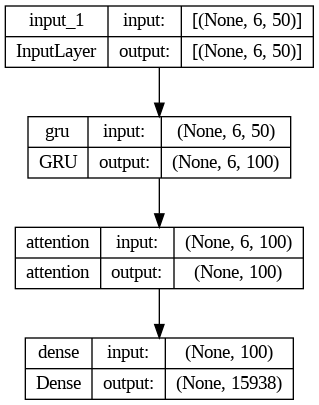

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Neural network: training

In [ ]:
model.fit(X_train, y_bow_train, epochs=5, batch_size=64, validation_split=.1)

Epoch 1/5
29/29 [==============================] - 6s 107ms/step - loss: 9.4149 - accuracy: 0.0114 - val_loss: 8.8525 - val_accuracy: 0.0000e+00
Epoch 2/5
29/29 [==============================] - 2s 58ms/step - loss: 7.3081 - accuracy: 0.0282 - val_loss: 9.2813 - val_accuracy: 0.0195
Epoch 3/5
29/29 [==============================] - 2s 60ms/step - loss: 6.8389 - accuracy: 0.0337 - val_loss: 9.6283 - val_accuracy: 0.0195
Epoch 4/5
29/29 [==============================] - 2s 56ms/step - loss: 6.7647 - accuracy: 0.0337 - val_loss: 9.8689 - val_accuracy: 0.0195
Epoch 5/5
29/29 [==============================] - 2s 58ms/step - loss: 6.7430 - accuracy: 0.0337 - val_loss: 10.0440 - val_accuracy: 0.0195


## Simple prediction


In [ ]:
words = list(decode_BOW.keys())


def predict_bow(sentence):
  sentence = sentence.lower()
  sentence_enc = []
  for token in sentence.split():
    try:
      sentence_enc.append(word_model.wv[token])
    except KeyError:
      sentence_enc.append(np.zeros(50))
  sentence_enc = np.array([sentence_enc])
  predicted_probabilities = model.predict(sentence_enc, verbose=0)[0]

  return decode_BOW[random.choices(words, weights=predicted_probabilities, k=1)[0]]

In [ ]:
for _ in range(5):
    sentence = 'He came to the conclusion that '
    print(predict_bow(sentence))

becoming.
agony.
which
look:
trembled:


# Neural network: prediction with temperature

In [ ]:
words = list(decode_BOW.keys())

def apply_temperature(a, temperature=0.7):
    # helper function to sample an index from a probability array
    a = np.log(a) / temperature
    a = np.exp(a) / np.sum(np.exp(a))
    return a


def predict_bow_with_temperature(sentence, temperature):
  sentence = sentence.lower()
  sentence_enc = []
  for token in sentence.split():
    try:
      sentence_enc.append(word_model.wv[token])
    except KeyError:
      sentence_enc.append(np.zeros(50))
  sentence_enc = np.array([sentence_enc])
  predicted_probabilities = model.predict(sentence_enc, verbose=0)[0]

  predicted_probabilities = apply_temperature(predicted_probabilities, temperature)

  return decode_BOW[random.choices(words, weights=predicted_probabilities, k=1)[0]]

In [ ]:
probabilities = [0.1, 0.2, 0.5]
for i in range(10):
    print(apply_temperature(probabilities, i))

[nan nan nan]
[0.125 0.25  0.625]
[0.21504074 0.30411354 0.48084572]
[0.2518957 0.3173687 0.4307356]
[0.27140313 0.32275453 0.40584234]
[0.28341233 0.32555528 0.3910324 ]
[0.29153477 0.32723672 0.38122851]
[0.29738995 0.32834512 0.37426493]
[0.30180914 0.3291252  0.36906566]
[0.30526215 0.32970136 0.3650365 ]


<ipython-input-80-1dbf34917c7b>:5: RuntimeWarning: divide by zero encountered in divide
  a = np.log(a) / temperature
<ipython-input-80-1dbf34917c7b>:6: RuntimeWarning: invalid value encountered in divide
  a = np.exp(a) / np.sum(np.exp(a))


In [ ]:
for _ in range(5):
    sentence = 'He came to the conclusion that '
    print(predict_bow_with_temperature(sentence, 3))

always
contrary.
‘worlding’,
undifferentiated.
evening.


In [ ]:
def generator (sentence: str):

  for i in range(10):
    new_word = (predict_bow_with_temperature(' '.join(sentence.split()[i:]), 3))
    sentence += ' ' + new_word

  return sentence

In [ ]:
# one shot

user_input = ''

user_input = input("enter ONE word: ")

print(generator(user_input))

enter ONE word: pursuit
pursuit here: why for. proved: Being, religion sources stale laugh: left.


# Linguistic analysis

In order to evaluate my answers linguistically, I will create an array with 10 generated answers, which will allow me to have more material to work with.

In [ ]:
samples = []

for i in range(10):
  user_input = ''
  user_input = input("enter ONE word: ")
  samples.append(generator(user_input))

print()
print(*samples, sep='\n\n')

enter ONE word: reject
enter ONE word: implode
enter ONE word: Pursue
enter ONE word: imagination
enter ONE word: Functionality
enter ONE word: verification
enter ONE word: Eagerly
enter ONE word: ugly
enter ONE word: Hopeful
enter ONE word: beautiful

reject object-state should, mention ‘alienation’, rejected, discontinuity negative). noema. Pastness, mist

implode Sciences: on. characteristic—being-in-itself Khrushchev’s done. extended. research: Hegel, rapid (whether

Pursue No Schlumberger. flabby solipsistic. concretely anarcho-syndicalists first fusion favorite Feuerbach,

imagination pose anti-Semitic obscured laugh looked contributor exigencies everything, action, eyes?”

Functionality Radice, formerly live: path row eloquence, spinning. fully. distant, action.

verification bachelors, explained—which hand: holding Scouts: see. pair appreciation sides, collectives

Eagerly telling changes! bundle bourgeois, writes, begs from, marry. linkage modification

ugly saved. renew separ

# Conclusion

As you can see, I used the variety of parts of the speach: nouns, verbs, adverbs and adjectives.

Additionally, I switched the case of the words to see how the NN would behave.

Sometimes the connection of POS works, e.g. 'reject object-state', but I don't see the pattern of, let's say, preferrable POS for generation.

The model definitely picked up the punctuation from the text, but not the letter capitalization or the length of the sentence in itself. They seem to be short. Maybe it's due to temperature being a bit too high.

There are some German words appearing, it could be due to citing inside the books that I've missed, because citations at the end were deleted.